In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import sys
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


## Load Data & Select Valid Countries

In [2]:
# Load the data

data_path = os.path.join('/Users/mila/code/sarahfink123/demand_prediction/raw_data/hotel_bookings_raw.csv')

df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
#Drop columns
df = df.drop(columns=['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status_date', 'MO_YR'])
#Drop duplicates
df.drop_duplicates(inplace=True)
#Drop none
df.dropna(inplace=True)

In [4]:
# # remove countries that appear too few times
# country_threshold = 5000
# # Step 1: Get the counts of each country
# country_counts = df['country'].value_counts()

# # Step 2: Filter countries with 1000 or more occurrences
# valid_countries = country_counts[country_counts >= country_threshold].index

# # Step 3: Filter the DataFrame to only include these valid countries
# filtered_df = df[df['country'].isin(valid_countries)]

# # Display the filtered DataFrame
# print(f"After removing countries appearing less than {country_threshold} times there are {len(filtered_df)} samples left")
# print(f"There are still {len(filtered_df['country'].unique())} countries")

In [5]:
valid_countries = ['PRT', 'GBR', 'ESP', 'FRA', 'DEU']

# Step 3: Filter the DataFrame to only include these valid countries
filtered_df = df[df['country'].isin(valid_countries)]

# Display the filtered DataFrame
# print(f"After removing countries appearing less than {country_threshold} times there are {len(filtered_df)} samples left")
print(f"There are still {len(filtered_df['country'].unique())} countries")
print(filtered_df['country'].unique())

There are still 5 countries
['PRT' 'GBR' 'ESP' 'FRA' 'DEU']


In [6]:
country_percentages = filtered_df['country'].value_counts(normalize=True) * 100

# Display the percentages
print(country_percentages)

country
PRT    45.420270
GBR    17.832893
FRA    15.115074
ESP    12.459796
DEU     9.171968
Name: proportion, dtype: float64


In [7]:
#Drop undefined

filtered_df = filtered_df[filtered_df["meal"] != "Undefined"]
filtered_df = filtered_df[filtered_df["market_segment"] != "Undefined"]
filtered_df = filtered_df[filtered_df["distribution_channel"] != "Undefined"]

print(f"After removing undefined values there are {len(filtered_df)} samples left")

After removing undefined values there are 55593 samples left


In [8]:
# Create the df that we will encode with to not change original data further
encoded_df = filtered_df.copy()

## Mapping & Encoding

In [9]:
#Change months to number
# Create a mapping of month names to numbers
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
#Strip spaces
encoded_df['arrival_date_month'] = encoded_df['arrival_date_month'].str.strip()
# Replace month names with numbers
encoded_df['arrival_date_month'] = encoded_df['arrival_date_month'].map(month_mapping)

#Change hotel to binary
hotel_mapping = {
    'City Hotel': 1,
    'Resort Hotel': 0
}
#Strip spaces
encoded_df['hotel'] = encoded_df['hotel'].str.strip()
# Replace month names with numbers
encoded_df['hotel'] = encoded_df['hotel'].map(hotel_mapping)

In [10]:
encoded_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'adr', 'reservation_status', 'CPI_AVG',
       'INFLATION', 'INFLATION_CHG', 'CSMR_SENT', 'UNRATE', 'INTRSRT', 'GDP',
       'FUEL_PRCS', 'CPI_HOTELS', 'US_GINI', 'DIS_INC'],
      dtype='object')

In [11]:
# perform 1 hot encoding of categorical values
# One Hot Encode meal, country, market_segment, distribution_channel, reservation_status -> categorical (3-5 categories, encoden)
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Columns to one-hot encode
# can add 'country' here to use it as a predictor
columns_to_encode = ['meal', 'market_segment', 'distribution_channel', 'reservation_status']

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids the dummy variable trap

# Fit and transform the data
one_hot_encoded_data = ohe.fit_transform(encoded_df[columns_to_encode])

# Convert encoded data to DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded_data, columns=ohe.get_feature_names_out(columns_to_encode))

# Concatenate the encoded columns with the original DataFrame
encoded_df = pd.concat([encoded_df.reset_index(drop=True), one_hot_df.reset_index(drop=True)], axis=1)

# Drop the original columns that were encoded
encoded_df.drop(columns=columns_to_encode, inplace=True)

# Display the first few rows of the updated DataFrame
print(one_hot_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55593 entries, 0 to 55592
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   meal_FB                       55593 non-null  float64
 1   meal_HB                       55593 non-null  float64
 2   meal_SC                       55593 non-null  float64
 3   market_segment_Complementary  55593 non-null  float64
 4   market_segment_Corporate      55593 non-null  float64
 5   market_segment_Direct         55593 non-null  float64
 6   market_segment_Groups         55593 non-null  float64
 7   market_segment_Offline TA/TO  55593 non-null  float64
 8   market_segment_Online TA      55593 non-null  float64
 9   distribution_channel_Direct   55593 non-null  float64
 10  distribution_channel_GDS      55593 non-null  float64
 11  distribution_channel_TA/TO    55593 non-null  float64
 12  reservation_status_Check-Out  55593 non-null  float64
 13  r

In [12]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler

features_to_robust = ['lead_time', 'arrival_date_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'adr', 'FUEL_PRCS']
robust_scaler = RobustScaler()
robust_scaler.fit(encoded_df[features_to_robust])
encoded_df[features_to_robust] = robust_scaler.transform(encoded_df[features_to_robust])
encoded_df.head()

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,country,is_repeated_guest,adr,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reservation_status_Check-Out,reservation_status_No-Show
0,0,0,2.684685,0.0,-0.5,-0.666667,0.0,PRT,0,-1.484375,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0,0,6.243243,0.0,-0.5,-0.666667,0.0,PRT,0,-1.484375,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0,0,-0.333333,0.0,-0.5,-0.333333,-1.0,GBR,0,-0.312500,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,-0.279279,0.0,-0.5,-0.333333,-1.0,GBR,0,-0.312500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0,-0.270270,0.0,-0.5,0.000000,0.0,GBR,0,0.046875,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [13]:
from sklearn.preprocessing import MinMaxScaler

features_to_minmax = ['CPI_AVG', 'INFLATION', 'INFLATION_CHG', 'CSMR_SENT', 'UNRATE', 'INTRSRT', 'GDP', 'DIS_INC', 'CPI_HOTELS']
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(encoded_df[features_to_minmax])
encoded_df[features_to_minmax] = minmax_scaler.transform(encoded_df[features_to_minmax])
encoded_df.head()

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,country,is_repeated_guest,adr,...,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reservation_status_Check-Out,reservation_status_No-Show
0,0,0,2.684685,0.0,-0.5,-0.666667,0.0,PRT,0,-1.484375,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0,0,6.243243,0.0,-0.5,-0.666667,0.0,PRT,0,-1.484375,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0,0,-0.333333,0.0,-0.5,-0.333333,-1.0,GBR,0,-0.312500,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,-0.279279,0.0,-0.5,-0.333333,-1.0,GBR,0,-0.312500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0,-0.270270,0.0,-0.5,0.000000,0.0,GBR,0,0.046875,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [14]:
#total stays
encoded_df['total_stays'] = encoded_df['stays_in_weekend_nights'] + encoded_df['stays_in_week_nights']
encoded_df['total_stays']


0       -1.166667
1       -1.166667
2       -0.833333
3       -0.833333
4       -0.500000
           ...   
55588    1.166667
55589    1.500000
55590    1.500000
55591    1.500000
55592    2.166667
Name: total_stays, Length: 55593, dtype: float64

## Model Selection & Training

In [15]:
# Assuming df_encoded is your DataFrame and adr is the target variable
target_variable = 'country'
predictors = encoded_df.columns.drop(target_variable)
#['arrival_date_month', 'adr', 'lead_time', 'total_stays', 'adults', 'hotel', 'INFLATION']

#if this doesnt work, label encode country first
X = encoded_df[predictors]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(encoded_df[target_variable])


In [16]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [23]:
# Train a RandomForestRegressor
estimators = [("RandomForrest", RandomForestClassifier(random_state=42)), ("GradientBoost", GradientBoostingClassifier(random_state=42))]
model = StackingClassifier(estimators=estimators)
model.fit(X_train, y_train)


StackingClassifier(estimators=[('RandomForrest',
                                RandomForestClassifier(random_state=42)),
                               ('GradientBoost',
                                GradientBoostingClassifier(random_state=42)),
                               ('NeuralNet',
                                MLPClassifier(alpha=1, max_iter=1000,
                                              random_state=42))])

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import ListedColormap

# from sklearn.datasets import make_circles, make_classification, make_moons
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.inspection import DecisionBoundaryDisplay
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier

# names = [
#    "Nearest Neighbors",
#     #"Linear SVM",
#     #"RBF SVM",
#     #"Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "GradientBoost",
# ]

# classifiers = [
#     KNeighborsClassifier(3),
#     #SVC(kernel="linear", C=0.025, random_state=42),
#     #SVC(gamma=2, C=1, random_state=42),
#     #GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
#     DecisionTreeClassifier(random_state=42),
#     RandomForestClassifier(random_state=42
#     ),
#     MLPClassifier(alpha=1, max_iter=1000, random_state=42),
#     AdaBoostClassifier(algorithm="SAMME", random_state=42),
#     GradientBoostingClassifier(random_state=42)
# ]

# scores = []
# for name, clf in zip(names, classifiers):
#     clf.fit(X_train, y_train)
#     score = clf.score(X_val, y_val)
#     scores.append((name, score))
#     print((name, score))

# scores

('Nearest Neighbors', 0.5091624508150646)
('Decision Tree', 0.4956717256885891)
('Random Forest', 0.5629005059021922)
('Neural Net', 0.5519955030916245)
('AdaBoost', 0.5217537942664419)
('GradientBoost', 0.5670601461495222)


[('Nearest Neighbors', 0.5091624508150646),
 ('Decision Tree', 0.4956717256885891),
 ('Random Forest', 0.5629005059021922),
 ('Neural Net', 0.5519955030916245),
 ('AdaBoost', 0.5217537942664419),
 ('GradientBoost', 0.5670601461495222)]

In [24]:
#cross val
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
y_pred = model.predict(X_val)
precision = precision_score(y_val, y_pred, average='weighted')
rec = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
print(precision, rec, f1, cv_scores.mean())


#with RandomForrest + GradientBoost stack: 0.5685279820672774 0.5901730876605249 0.5706492871547616 0.5791545602428511


0.5623086014445967 0.5832490163012929 0.5641918383984056


In [28]:
from demand_predictor.ml_logic.registry import save_model
save_model(model)

✅ Model saved locally at /Users/mila/code/sarahfink123/demand_prediction/demand_predictor/../training_outputs/models/20240531-152651.pkl


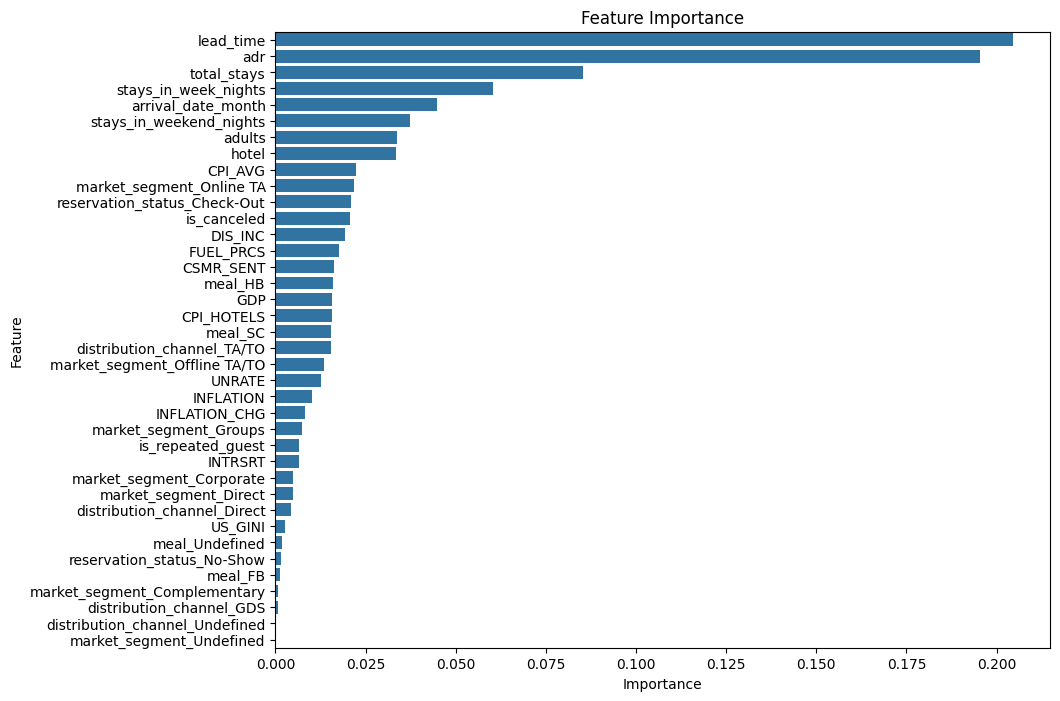

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

0.987287753621896 0.9872860515443636 0.9872741960483408 0.6226636375858824


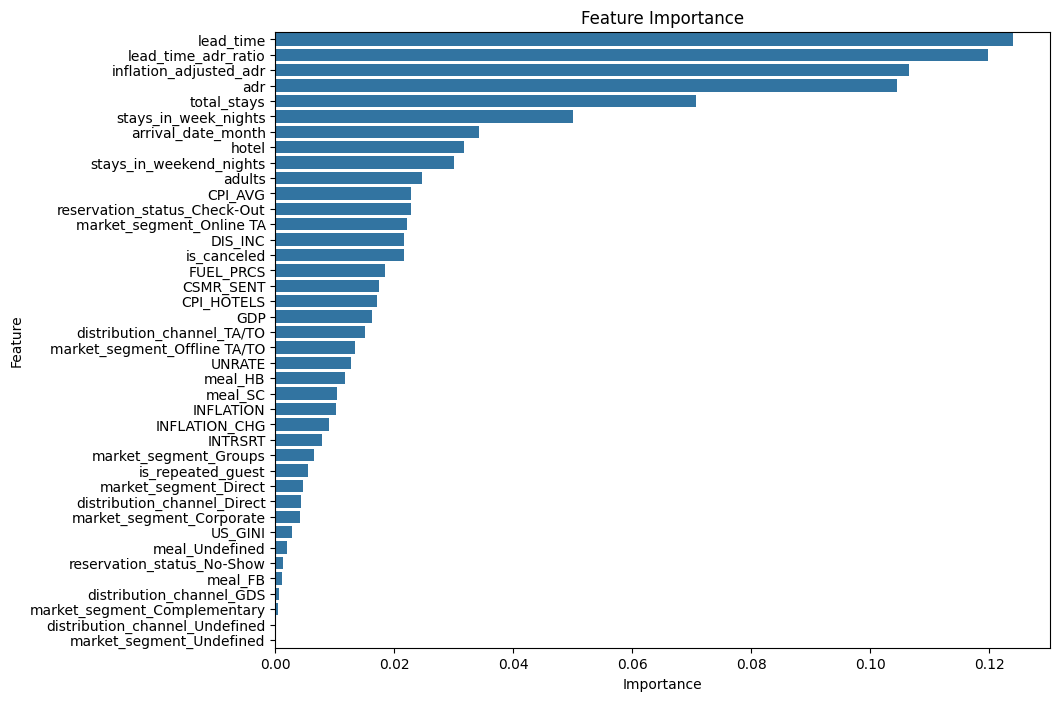

In [ ]:

# # Make predictions on the test set
# y_pred = model.predict(X_test)
# precision = precision_score(X_val, y_val, average='weighted')
# rec = recall_score(y_val, y_pred, average='weighted')
# f1 = f1_score(y_train, y_pred, average='weighted')
# print(precision, rec, f1, cv_scores.mean())


In [ ]:
importances

array([3.35198632e-02, 2.06965087e-02, 2.04698837e-01, 4.47262320e-02,
       3.72033742e-02, 6.03028305e-02, 3.38306530e-02, 6.56767375e-03,
       1.95529417e-01, 2.22712995e-02, 1.01087812e-02, 8.34212522e-03,
       1.63352227e-02, 1.27684420e-02, 6.43868348e-03, 1.58207802e-02,
       1.75349711e-02, 1.56844203e-02, 2.54949263e-03, 1.91951668e-02,
       1.19512723e-03, 1.59189447e-02, 1.55155441e-02, 1.74028127e-03,
       7.14997462e-04, 4.92944260e-03, 4.83341542e-03, 7.35916724e-03,
       1.35564168e-02, 2.17268290e-02, 0.00000000e+00, 4.32056295e-03,
       6.79516118e-04, 1.53602167e-02, 1.62375288e-06, 2.10316963e-02,
       1.58227274e-03, 8.54091709e-02])

In [25]:
country_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
pred = y_pred[1]
pred_name = country_mapping[pred]
pred_name

'PRT'

## Option 1: Feature Permutation for choosing the most relevant features

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val,
                           n_repeats=10,
                           random_state=0)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]:<8}\t"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

hotel   	0.070 +/- 0.003
lead_time	0.035 +/- 0.003
adr     	0.023 +/- 0.002
reservation_status_Check-Out	0.018 +/- 0.002
total_stays	0.014 +/- 0.003
is_canceled	0.010 +/- 0.002
market_segment_Online TA	0.007 +/- 0.002
meal_HB 	0.004 +/- 0.001
market_segment_Offline TA/TO	0.003 +/- 0.001
distribution_channel_TA/TO	0.003 +/- 0.002
stays_in_week_nights	0.003 +/- 0.002
meal_SC 	0.002 +/- 0.001
market_segment_Groups	0.002 +/- 0.001
adults  	0.002 +/- 0.001
is_repeated_guest	0.002 +/- 0.001
meal_Undefined	0.001 +/- 0.000
arrival_date_month	0.000 +/- 0.002
meal_FB 	0.000 +/- 0.000
reservation_status_No-Show	0.000 +/- 0.000
market_segment_Complementary	0.000 +/- 0.000
distribution_channel_Undefined	0.000 +/- 0.000
market_segment_Undefined	0.000 +/- 0.000
distribution_channel_GDS	-0.000 +/- 0.000
market_segment_Corporate	-0.001 +/- 0.001
US_GINI 	-0.002 +/- 0.001
UNRATE  	-0.002 +/- 0.002
market_segment_Direct	-0.002 +/- 0.001
INTRSRT 	-0.003 +/- 0.001
distribution_channel_Direct	-0.003 +/- 0.0

## Option 2: Calculate the mean/median/mode for every column 

In [26]:
#variables of interest
# target_variable = 'country_name'
# predictors = ['arrival_date_month', 'adr', 'lead_time', 'stays_in_week_nights', 'adults', 'hotel', 'INFLATION']

In [ ]:
# means
column_means = encoded_df.drop(columns=["country"]).mean()
column_means

#pick the variables that we dont in our input and fill the variables of interest with the input of the user

hotel                              0.564345
is_canceled                        0.286095
lead_time                          0.298133
arrival_date_month                -0.097634
stays_in_weekend_nights           -0.001072
stays_in_week_nights               0.207389
adults                            -0.130048
is_repeated_guest                  0.049853
adr                                0.146220
CPI_AVG                            0.531175
INFLATION                          0.638980
INFLATION_CHG                      0.626027
CSMR_SENT                          0.523092
UNRATE                             0.361816
INTRSRT                            0.391229
GDP                                0.530422
FUEL_PRCS                         -0.178096
CPI_HOTELS                         0.534307
US_GINI                           41.150354
DIS_INC                            0.495234
meal_FB                            0.005539
meal_HB                            0.121096
meal_SC                         

In [ ]:
# medians
column_medians = encoded_df.drop(columns=["country"]).median()
column_medians

#pick the variables that we dont in our input and fill the variables of interest with the input of the user

hotel                              1.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_month                 0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
is_repeated_guest                  0.000000
adr                                0.000000
CPI_AVG                            0.496064
INFLATION                          0.714286
INFLATION_CHG                      0.666667
CSMR_SENT                          0.522124
UNRATE                             0.428571
INTRSRT                            0.250000
GDP                                0.499259
FUEL_PRCS                          0.000000
CPI_HOTELS                         0.534638
US_GINI                           41.200000
DIS_INC                            0.404358
meal_FB                            0.000000
meal_HB                            0.000000
meal_SC                         

In [ ]:
# modes
column_modes = encoded_df.drop(columns=["country"]).mode()
column_modes

#pick the variables that we dont in our input and fill the variables of interest with the input of the user

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,adr,CPI_AVG,...,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reservation_status_Check-Out,reservation_status_No-Show,total_stays
0,1,0,-0.396396,0.2,-0.5,-0.333333,0.0,0,-1.484375,0.285164,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.833333
